In [77]:
# -*- coding: utf-8 -*-
# -*- author : Lokman Mheni - Fabio Palmisano -*-
# -*- date : 2024-04-20 -*-
# -*- Last revision: 2024-05-14 *-
# -*- python version : 3.11.9 -*-
# -*- Description: Logistic Regression-*-

# <center> EE - 452: Network Machine Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Bookreads recommenders </center>
---

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from itertools import combinations
from collections import defaultdict
from tqdm import tqdm

#!pip install grakel
from grakel import GraphKernel
from grakel.utils import graph_from_networkx
from tqdm import tqdm


tr = pd.read_csv( 'data/to_read.csv' )


In [2]:
tr.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [23]:
# Check how many times each book has been added to 'to read'
a = tr['book_id'].value_counts()

In [24]:
a.loc[1657]

858

In [4]:
r = pd.read_csv( 'data/ratings.csv' )

In [26]:
r.query( 'book_id == 1657' )

,user_id,book_id,rating
470,34,1657,5
3469,116,1657,5
4811,212,1657,2
10303,420,1657,5
10469,485,1657,3
...,...,...,...
5920228,19843,1657,1
5929620,5925,1657,4
5932533,52300,1657,5
5941724,1364,1657,3


In [21]:
# Check how many times each book has been rated by users and the average rating and  Check how many times each book has been added to 'to read', store all in a dataframe
r['book_id'].value_counts()
r.groupby('book_id')['rating'].mean()
ratings = pd.DataFrame( r['book_id'].value_counts() )
ratings.columns = ['n_ratings']
ratings['avg_rating'] = r.groupby('book_id')['rating'].mean()
ratings['book_id'] = ratings.index
ratings = ratings.reset_index( drop = True )
# Count the number of times each book is marked as "to read"
to_read_counts = tr['book_id'].value_counts()

# Add this information to the ratings dataframe
ratings['to_read_count'] = ratings['book_id'].map(to_read_counts)

# Fill NaN values with 0 (for books that were never marked as "to_read")
ratings['to_read_count'] = ratings['to_read_count'].fillna(0)
ratings['to_read_count'] = ratings['to_read_count'].astype(int)

ratings["perc_to_read"] = (ratings["to_read_count"] / ratings["n_ratings"])*100
ratings

,n_ratings,avg_rating,book_id,to_read_count,perc_to_read
0,22806,4.279707,1,973,4.266421
1,21850,4.351350,2,400,1.830664
2,19088,4.329369,4,1478,7.743085
3,16931,3.214341,3,287,1.695115
4,16604,3.772224,5,1293,7.787280
...,...,...,...,...,...
9995,36,3.722222,9315,17,47.222222
9996,33,3.757576,1935,5,15.151515
9997,24,4.041667,9486,2,8.333333
9998,11,3.545455,9345,1,9.090909


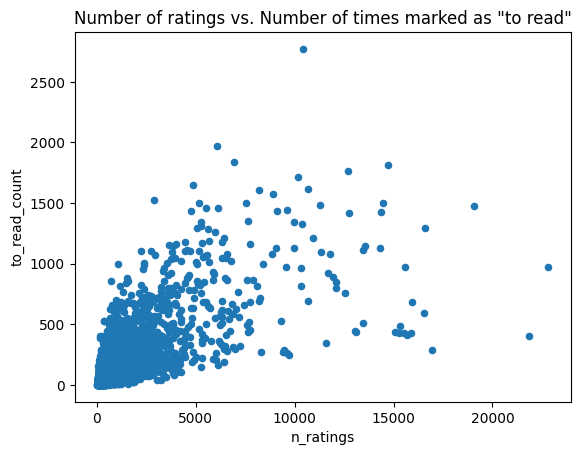

0.7292942930615238

In [31]:
# Can we see if there exists a correlation between the number of times a book is marked as "to read" and the number of ratings he received ? 
ratings.plot.scatter( x = 'n_ratings', y = 'to_read_count' )
plt.title( 'Number of ratings vs. Number of times marked as "to read"' )
plt.show()

correlation = ratings['to_read_count'].corr(ratings['n_ratings'])
correlation

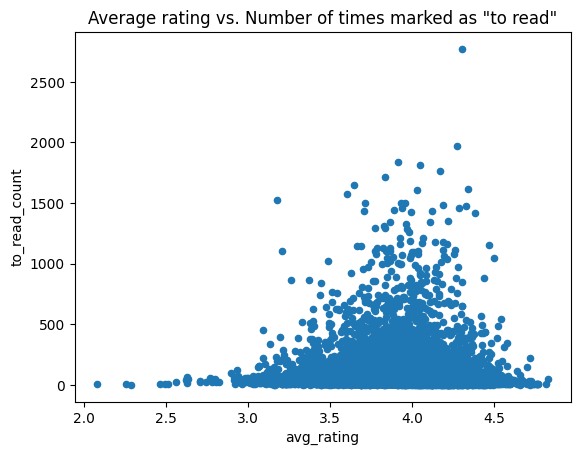

0.0036904096044729907

In [33]:
#But now we want to see if there is a correlation between the average rating of a book and the number of times it has been marked as "to read"
ratings.plot.scatter( x = 'avg_rating', y = 'to_read_count' )
plt.title( 'Average rating vs. Number of times marked as "to read"' )
plt.show()

correlation = ratings['to_read_count'].corr(ratings['avg_rating'])
correlation

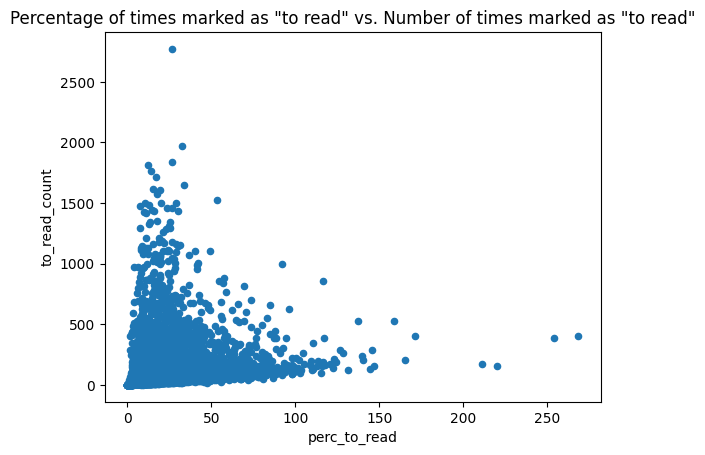

0.2242995370619817

In [34]:
#And now we want to see if there is a correlation between percentage of times a book is marked as "to read" and the number of times it has been marked to read 
ratings.plot.scatter( x = 'perc_to_read', y = 'to_read_count' )
plt.title( 'Percentage of times marked as "to read" vs. Number of times marked as "to read"' )
plt.show()

correlation = ratings['to_read_count'].corr(ratings['perc_to_read'])
correlation

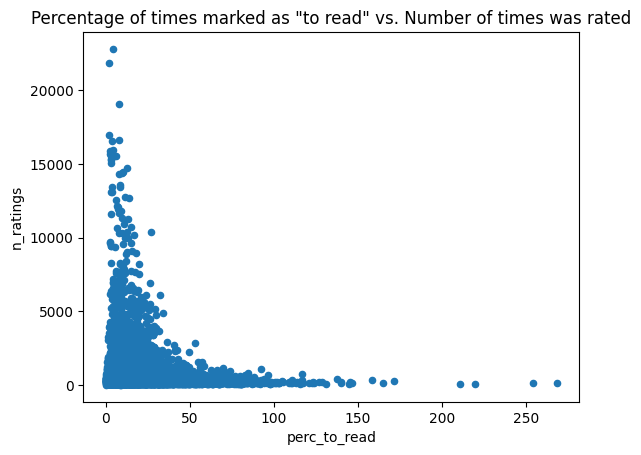

-0.11977616908195686

In [35]:
#And now we want to see if there is a correlation between percentage of times a book is marked as "to read" and the number of times it has been marked to read 
ratings.plot.scatter( x = 'perc_to_read', y = 'n_ratings' )
plt.title( 'Percentage of times marked as "to read" vs. Number of times was rated' )
plt.show()

correlation = ratings['n_ratings'].corr(ratings['perc_to_read'])
correlation

In [22]:
ratings.query('perc_to_read > 100')

,n_ratings,avg_rating,book_id,to_read_count,perc_to_read
1698,736,4.084239,1657,858,116.576087
3301,382,3.963351,3103,525,137.434555
3732,334,4.026946,4032,530,158.682635
3804,328,4.329268,3952,384,117.073171
3973,313,3.932907,4581,346,110.543131
4874,254,4.291339,2263,266,104.724409
5206,237,3.902954,5259,406,171.308017
5475,224,3.843750,4624,284,126.785714
5613,218,3.788991,5320,219,100.458716
5909,207,3.879227,6799,266,128.502415


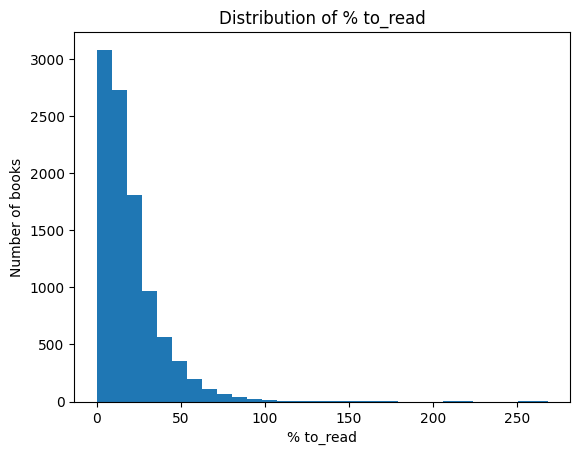

In [13]:
#Plot the distribution of the %  to_read 
plt.hist(ratings["% to_read"], bins = 30)
plt.xlabel('% to_read')
plt.ylabel('Number of books')
plt.title('Distribution of % to_read')
plt.show()



In [37]:
# Check how many times a book has only one user who added it to 'to read'
(tr['book_id'].value_counts() < 50).sum()

5641

In [82]:
# Create a dictionary where the keys are user_ids and the values are sets of book_ids
user_books = defaultdict(set)

# Populate the dictionary
for _, row in tqdm(tr.iterrows(), total=tr.shape[0]):
    user_books[row['user_id']].add(row['book_id'])


100%|██████████| 912705/912705 [00:29<00:00, 31422.63it/s]


In [83]:
import random

# Select a random subset of users
user_subset = random.sample(list(user_books.keys()), 1000)

# Create an empty graph
G_user_books_sample = nx.Graph()

# Iterate over each user in the subset
for user_id in tqdm(user_subset, total=len(user_subset)):
    # Get the books for this user
    books = user_books[user_id]
    
    # Generate all pairs of books for this user
    book_pairs = combinations(books, 2)
    
    # Add edges between all pairs of books
    for book_pair in book_pairs:
        G_user_books_sample.add_edge(*book_pair, user_id=user_id)

# Print the number of nodes and edges in the sampled graph
print(len(G_user_books_sample.nodes()))
print(len(G_user_books_sample.edges()))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2443.00it/s]

5639
251623


In [84]:
number_to_read =  tr['book_id'].value_counts()
number_to_read = number_to_read.apply(lambda x: 1 if x >= 100 else 0)
number_to_read

book_id
47      1
143     1
113     1
13      1
11      1
       ..
6297    0
7951    0
4434    0
9124    0
8946    0
Name: count, Length: 9986, dtype: int64

In [85]:
number_to_read.count()

9986

In [86]:
number_to_read.value_counts()

count
0    7713
1    2273
Name: count, dtype: int64

In [87]:
nx.set_node_attributes(G_user_books_sample, number_to_read.to_dict(), 'to_read')

In [88]:
# Can we compare what we have in graph_labels and what we have in the graph nodes ? 
# The answer is yes, we can compare the two lists and check if they are the same.
# We can do this by using the following code:
set(G_user_books_sample.nodes()).issubset(set(number_to_read.index))


True

In [89]:
#check in G_user_books_sample the proportion of nodes set to label 1 (to read) and which are set to 0 (not to read)
to_read = 0
not_to_read = 0
for node in G_user_books_sample.nodes(data=True):
    if node[1]['to_read'] == 1:
        to_read += 1
    else:
        not_to_read += 1
print(to_read, not_to_read)

2180 3459


In [90]:
graph_labels = nx.get_node_attributes(G_user_books_sample, 'to_read')
graph_labels

{3488: 1,
 870: 1,
 7455: 1,
 7425: 0,
 1167: 1,
 143: 1,
 4879: 0,
 6932: 1,
 663: 1,
 1184: 1,
 3491: 1,
 4004: 0,
 39: 1,
 7209: 0,
 1577: 1,
 430: 1,
 46: 1,
 1710: 1,
 2613: 1,
 439: 1,
 60: 1,
 959: 1,
 1988: 1,
 68: 1,
 587: 1,
 974: 1,
 4307: 1,
 468: 1,
 8788: 0,
 470: 1,
 119: 1,
 736: 1,
 6241: 0,
 737: 1,
 867: 1,
 2403: 1,
 103: 1,
 236: 1,
 5101: 1,
 9202: 0,
 630: 1,
 5623: 0,
 33: 1,
 217: 1,
 1926: 1,
 424: 1,
 4906: 0,
 687: 1,
 47: 1,
 881: 1,
 3349: 1,
 21: 1,
 3543: 1,
 24: 1,
 6425: 1,
 3745: 1,
 4962: 1,
 6691: 0,
 1699: 1,
 193: 1,
 9422: 0,
 4659: 0,
 6964: 0,
 3161: 0,
 730: 1,
 1723: 1,
 2974: 0,
 2687: 0,
 516: 1,
 653: 1,
 117: 1,
 534: 1,
 7002: 0,
 2439: 0,
 9624: 0,
 8992: 0,
 1185: 1,
 290: 1,
 677: 1,
 3504: 1,
 8242: 0,
 5944: 1,
 8891: 0,
 2621: 0,
 4670: 0,
 4039: 1,
 591: 1,
 9295: 0,
 338: 1,
 4050: 0,
 7771: 0,
 869: 1,
 378: 1,
 4850: 0,
 1909: 1,
 7543: 0,
 2298: 1,
 1027: 1,
 3975: 0,
 1032: 1,
 149: 1,
 2838: 1,
 1045: 1,
 3607: 1,
 1022: 1,


In [91]:
seed = 42
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

## We want for each node take is degree, closeness centrality, betweeness centrality as features and that make a model to predict if it's a blockbuster (1 in to read) or not 
# Create a DataFrame with the degree, closeness centrality, and betweenness centrality of each node
node_features = pd.DataFrame(index=G_user_books_sample.nodes())

# Calculate the degree of each node
node_features['degree'] = pd.Series(dict(G_user_books_sample.degree()))

# Calculate the degree centrality of each node
node_features['degree_centrality'] = pd.Series(degree_centrality(G_user_books_sample))

# Calculate the closeness centrality of each node
node_features['closeness'] = pd.Series(nx.closeness_centrality(G_user_books_sample))

# Calculate the betweenness centrality of each node
node_features['betweenness'] = pd.Series(nx.betweenness_centrality(G_user_books_sample))

#Calculate the clustering coefficient of each node
node_features['clustering'] = pd.Series(nx.clustering(G_user_books_sample))

# Calculate the eigenvector centrality of each node
node_features['eigenvector'] = pd.Series(nx.eigenvector_centrality(G_user_books_sample))

# Calculate the pagerank of each node
node_features['pagerank'] = pd.Series(nx.pagerank(G_user_books_sample))

# Calculate the average neighbor degree of each node
node_features['average_neighbor_degree'] = pd.Series(nx.average_neighbor_degree(G_user_books_sample))

# Merge the node features with the graph labels
node_features = node_features.merge(pd.Series(graph_labels, name ='graph_labels'), left_index=True, right_index=True)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train a simple model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})


[0 0 1 ... 0 1 0]
Accuracy:  0.8114657210401891
F1 Score:  0.7343880099916735


,Real,Predicted
8165,0,0
3337,1,0
710,1,1
6827,0,0
2838,1,1
...,...,...
3044,0,0
17,1,1
4095,0,0
4727,0,1


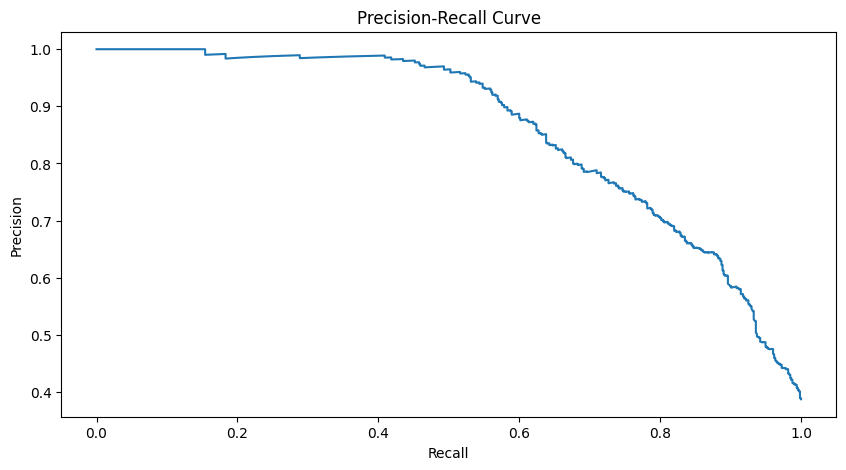

In [92]:
from sklearn.metrics import precision_recall_curve

# Get the probabilities of the positive class
y_scores = model.predict_proba(X_test)[:, 1]

# Get the precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Find the threshold that gives the best F1 score
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]

# Use this threshold to predict the classes
y_pred = (y_scores > best_threshold).astype(int)

# Print the precision-recall curve for the model 
plt.figure(figsize=(10, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

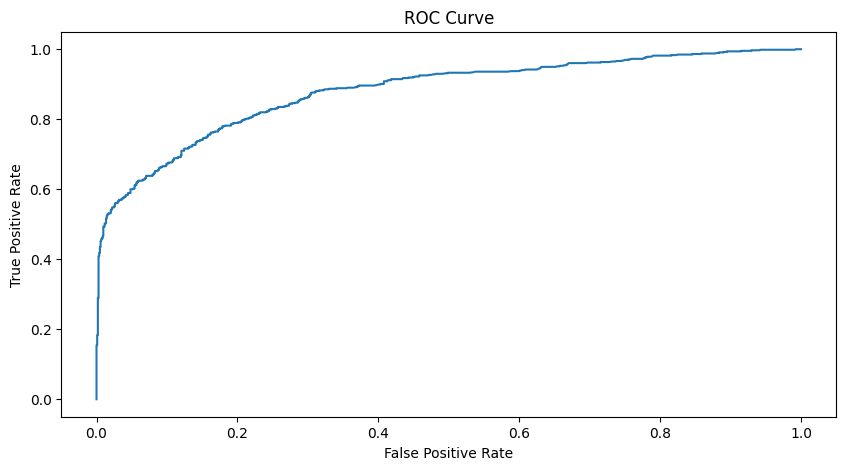

In [93]:
# Plot the ROC curve
from sklearn.metrics import roc_curve

# Get the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot the ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [94]:
node_features

,degree,closeness,betweenness,clustering,eigenvector,pagerank,average_neighbor_degree,graph_labels
3488,135,0.458656,0.000265,0.411719,0.014993,0.000245,274.162963,1
870,216,0.472395,0.000844,0.301809,0.022839,0.000384,260.194444,1
7455,53,0.409246,0.000025,0.505080,0.003460,0.000121,183.377358,1
7425,49,0.425645,0.000011,0.700680,0.005783,0.000104,299.244898,0
1167,354,0.489608,0.000598,0.260527,0.038536,0.000559,260.694915,1
...,...,...,...,...,...,...,...,...
6777,58,0.421218,0.000000,1.000000,0.006680,0.000116,292.103448,0
2724,3,0.350103,0.000000,1.000000,0.000491,0.000031,376.666667,0
4753,11,0.359630,0.000000,1.000000,0.000628,0.000050,163.818182,0
7476,11,0.359630,0.000000,1.000000,0.000628,0.000050,163.818182,0


In [95]:
# Now can we try to make different combinaisons of features to see what has the best accuracy and F1 score and store the result in a datafram in order to print the best combinaison
from sklearn.metrics import f1_score

# Create a DataFrame to store the results
results = pd.DataFrame(columns=['features', 'accuracy', 'f1_score'])

# Iterate over all possible combinations of features
for i in range(1, len(node_features.columns) - 1):
    for features in combinations(node_features.columns[:-1], i):
        print(features)
        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(node_features[list(features)], node_features['graph_labels'], test_size=0.3, random_state=seed)

        # Train a simple model
        model = LogisticRegression()
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate the accuracy and F1 score of the model
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

       # Append the results to the DataFrame
        results.loc[len(results)] = [features, accuracy, f1]
        print(accuracy, f1)

# Print the results
results.sort_values('f1_score', ascending=False).head(10)

# Print the best combinaison
best_combinaison = results.sort_values('f1_score', ascending=False).iloc[0]
print("Best combinaison of features:")
print(best_combinaison['features'])
print("Accuracy:", best_combinaison['accuracy'])
print("F1 Score:", best_combinaison['f1_score'])


('degree',)
0.8132387706855791 0.723292469352014
('closeness',)
0.8073286052009456 0.7052441229656421
('betweenness',)
0.6128841607565012 0.0
('clustering',)
0.791371158392435 0.734785875281743
('eigenvector',)
0.624113475177305 0.05637982195845697
('pagerank',)
0.6128841607565012 0.0
('average_neighbor_degree',)
0.5591016548463357 0.08578431372549018
('degree', 'closeness')
0.8132387706855791 0.723292469352014
('degree', 'betweenness')
0.8132387706855791 0.723292469352014
('degree', 'clustering')
0.8073286052009456 0.7269681742043551
('degree', 'eigenvector')
0.8132387706855791 0.723292469352014
('degree', 'pagerank')
0.8132387706855791 0.723292469352014
('degree', 'average_neighbor_degree')
0.8126477541371159 0.7221735319894829
('closeness', 'betweenness')
0.8073286052009456 0.7052441229656421
('closeness', 'clustering')
0.8055555555555556 0.7431693989071038
('closeness', 'eigenvector')
0.8073286052009456 0.7047101449275363
('closeness', 'pagerank')
0.8073286052009456 0.7052441229656

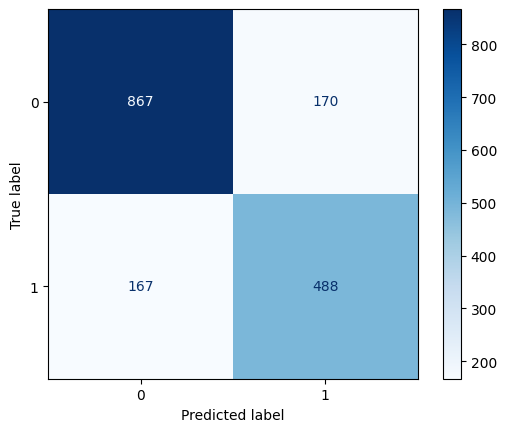

In [96]:
# Plot the matrix of confusion
from sklearn.metrics import ConfusionMatrixDisplay

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.show()



In [97]:
# Make the same but with an other model 
from sklearn.ensemble import RandomForestClassifier

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features[list(best_combinaison['features'])], node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train a simple model
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

Accuracy:  0.7949172576832151
F1 Score:  0.7171964140179299


In [98]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train a simple model
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

[0 1 1 ... 1 0 0]
Accuracy:  0.7972813238770685
F1 Score:  0.7236099919419822


,Real,Predicted
8165,0,0
3337,1,1
710,1,1
6827,0,0
2838,1,1
...,...,...
3044,0,0
17,1,1
4095,0,1
4727,0,0


In [99]:
#Try with SVM
from sklearn.svm import SVC

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train a simple model
model = SVC(probability=True)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

[0 0 1 ... 0 0 0]
Accuracy:  0.8096926713947991
F1 Score:  0.6973684210526316


,Real,Predicted
8165,0,0
3337,1,0
710,1,1
6827,0,0
2838,1,1
...,...,...
3044,0,0
17,1,1
4095,0,0
4727,0,0
